# FIRST NOTEBOOK : LUNG SEGMENTATION

## 1.1) Loading and Processing images

In [ ]:
# Importing required libraries

# TF libraries for DL
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, UpSampling2D, Reshape
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import metrics

# Usual Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from tqdm import tqdm_notebook

# Image Processing Libraries
from PIL import Image
import cv2
from matplotlib.pyplot import imshow

# For GPU usage
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#session = tf.Session(config=config)

# Warnings removal
import warnings
warnings.filterwarnings('ignore')

# Preloading pix2pix module from tensorflow
!pip install -q git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

# Preloading EfficientNet
!pip3 install -q efficientnet
import efficientnet.tfkeras as efn

In [ ]:
# Specifying data repositories

fold_dir = './'
metadata_dir = './metadata.csv'
metadata = pd.read_csv(metadata_dir)
masks_dir = './annotations/lungVAE-masks/'


data_X = [] # Images
data_Y = [] # Labels
im_mask = [] # Images for which we posess masks
masks = [] # Corresponding masks
label_mask = [] # Mask labels

# Retrieving and processing images
for i in range (len(metadata)):
    if metadata['folder'][i] != 'volumes': # Not processing the volume folder
        if metadata['view'][i] == 'AP' or metadata['view'][i] == 'PA' or metadata['view'][i] == 'AP Supine' :
            
            a = cv2.imread(fold_dir + metadata['folder'][i] + '/' + metadata['filename'][i]) # Retrieve image

            if metadata['filename'][i][-4:] == 'jpeg': # Check if the image has a mask
                b = cv2.imread(masks_dir + metadata['filename'][i][:-5] + '_mask' + '.png')
            
            else :
                b = cv2.imread(masks_dir + metadata['filename'][i][:-4] + '_mask'+ '.png')
    
            if b is not None :                
                masks.append(b) # Adding this mask to the list of masks
                im_mask.append(a) # Adding the image to the list of images with masks
            
            data_X.append(cv2.resize(a,(224,224))) # Adding image to the dataset
            
            if 'COVID-19' in metadata['finding'][i]: # Getting image's label (1: covid, 0: normal)
                data_Y.append(1)
            else : 
                data_Y.append(0)
            
            if 'COVID-19' in metadata['finding'][i] and b is not None: # Getting masks' label (if any)
                label_mask.append(1)
            elif b is not None: 
                label_mask.append(0)

Le nombre de masques est correct: True


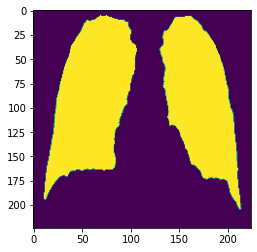

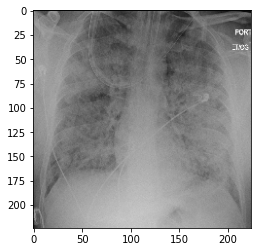

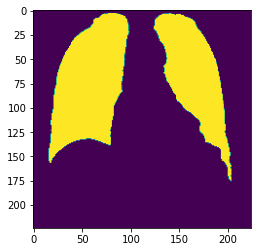

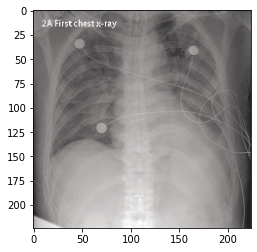

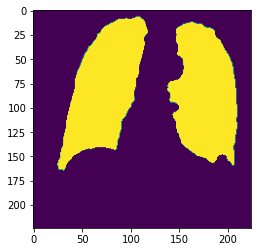

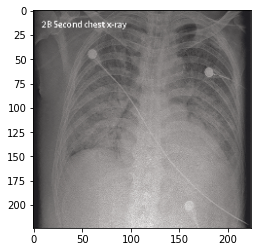

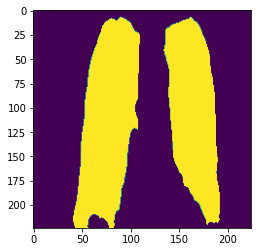

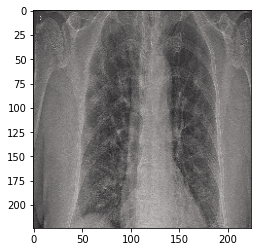

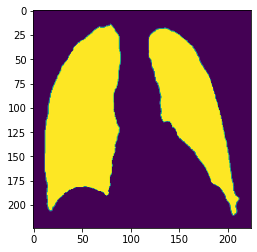

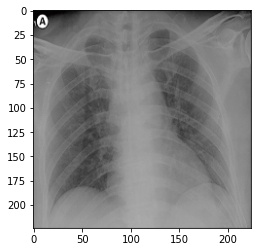

In [ ]:
# WARNING : THIS CELL MUST BE RAN EXACTLY ONCE
# Resizing images and masks

for i in range(len(im_mask)):
    im_mask[i]=cv2.resize(im_mask[i],(224,224)) # Resizing images
    im_mask[i]=im_mask[i]/255 # Normalizing images
    masks[i] = tf.image.rgb_to_grayscale(cv2.resize(masks[i],(224,224))) # Converting masks to grayscale and resizing
    masks[i] = masks[i]/255 # Normalizing masks

# Checking if there is exactly the same number of images with masks and corresponding masks
print('Correct number of masks:',len(im_mask) == len(masks))

# Checking that images and masks match  
for i in range(5):
    plt.figure(i+1)
    plt.imshow(masks[i]) # masks
    plt.show()
    plt.imshow(im_mask[i]) # images
    plt.show()

## 1.2) Building a CNN using U-NET, known to be proficient in medical imaging

In [ ]:
# Creating training and validation repositories
# Images have been normalized already

train_img,train_label = im_mask[0:150],masks[0:150] # training
test_img,test_label = im_mask[150:],masks[150:] # validation

In [ ]:
# Preloading a base model from Keras
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)

# Importing the following layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
               ]
layers = [base_model.get_layer(name).output for name in layer_names]

# Building the feature extractor (Encoding)
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

# Building the decoding module using Tensorflow
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
           ]

In [ ]:
# Creating the U-NET model for pixel labelling

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=(224, 224, 3))
  x = inputs

  # Compressing using the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Decoding
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # Last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
# 3 possible classes for a pixel :
OUTPUT_CHANNELS = 3 
# Classe 1 : Pixel inside the interest zone of the scan
# Classe 2 : Pixel at the edge of the interest zone of the scan
# Classe 3 : Pixel outside the interest zone of the scan

# Compiling our model
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # No softmax, loss processes raw data
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, 112, 112, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 14, 14, 512)  1476608     functional_1[0][4]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 14, 14, 1088) 0           sequential[0][0]                 
                                                                 functional_1[0][3]    

## 1.3) Training the network

In [ ]:
# Creating training and validation datasets
dataset = tf.data.Dataset.from_tensor_slices((train_img,train_label))
train_dataset = dataset.batch(32) # training


dataset2 = tf.data.Dataset.from_tensor_slices((test_img,test_label))
test_dataset = dataset2.batch(32) # validation

In [ ]:
# Training using images
segmentation_history = model.fit(train_dataset,validation_data = test_dataset,batch_size=32,epochs=30)

Epoch 1/30
5/5 [==============================] - 2s 346ms/step - loss: 0.3746 - accuracy: 0.8411 - val_loss: 0.3040 - val_accuracy: 0.8949
Epoch 2/30
5/5 [==============================] - 1s 125ms/step - loss: 0.2666 - accuracy: 0.9112 - val_loss: 0.2268 - val_accuracy: 0.9197
Epoch 3/30
5/5 [==============================] - 1s 136ms/step - loss: 0.2106 - accuracy: 0.9384 - val_loss: 0.1871 - val_accuracy: 0.9303
Epoch 4/30
5/5 [==============================] - 1s 124ms/step - loss: 0.1756 - accuracy: 0.9463 - val_loss: 0.1658 - val_accuracy: 0.9373
Epoch 5/30
5/5 [==============================] - 1s 125ms/step - loss: 0.1496 - accuracy: 0.9511 - val_loss: 0.1586 - val_accuracy: 0.9396
Epoch 6/30
5/5 [==============================] - 1s 131ms/step - loss: 0.1300 - accuracy: 0.9559 - val_loss: 0.1537 - val_accuracy: 0.9407
Epoch 7/30
5/5 [==============================] - 1s 130ms/step - loss: 0.1161 - accuracy: 0.9594 - val_loss: 0.1458 - val_accuracy: 0.9429
Epoch 8/30
5/5 [====

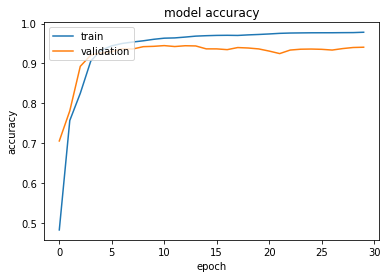

In [ ]:
# Printing Accuracy

plt.plot(segmentation_history.history['accuracy'])
plt.plot(segmentation_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Processing masks so we can add them to the images (black or white)
def format(mask):
  mask = tf.argmax(mask, axis=-1) # Getting max indices along the last dimension
  mask = mask[..., tf.newaxis] # Adding new axis
  return mask

## 1.4) Generating masks for all our images

In [ ]:
# We now use our network to generate masks for every image
# Creating a dataset containing every image
fullset = data_X.copy()
for i in range(np.shape(data_X)[0]):
    fullset[i]=fullset[i]/255 # Normalizing
fulldata = tf.data.Dataset.from_tensor_slices(fullset) # Creating dataset
fulldataset = fulldata.batch(64)
print('vérifions les dimensions:', fulldataset)



vérifions les dimensions: <BatchDataset shapes: (None, 224, 224, 3), types: tf.float64>


In [ ]:
# Predicting masks
fullpred = model.predict(fulldataset)

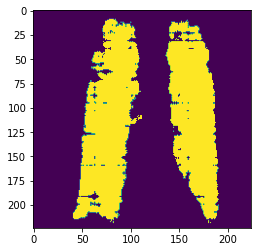

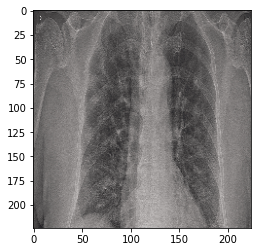

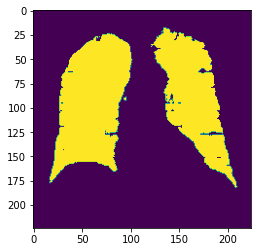

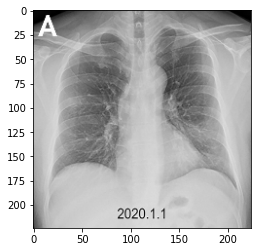

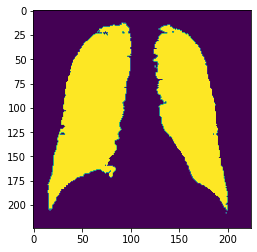

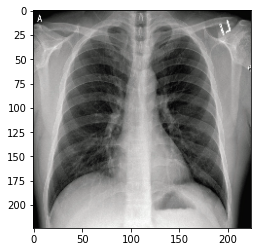

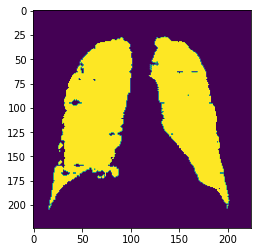

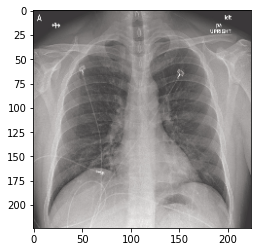

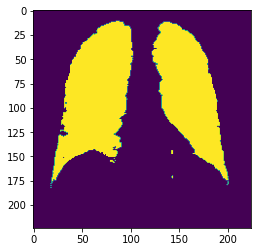

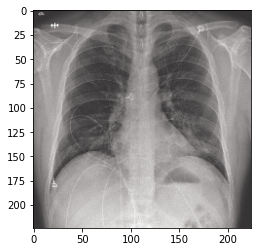

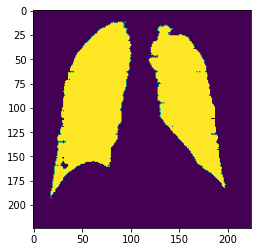

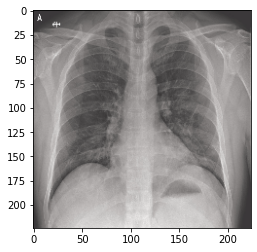

In [ ]:
# Let us check the masks generated by the network
for i in range(20,26):
    plt.figure(i+1)
    plt.imshow(format(fullpred[i])) # masques
    plt.show()
    plt.imshow(data_X[i]) # images
    plt.show()


In [ ]:
# Adding the mask to our images
# Creating a list containing every masked image

imgmask = [] # Masked images, unnormalized
for i in range(np.shape(data_X)[0]):
    imgmask.append(np.array(data_X[i]*format(fullpred[i])))

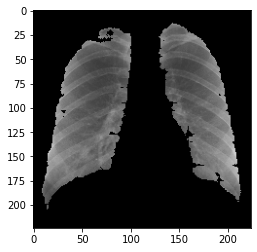

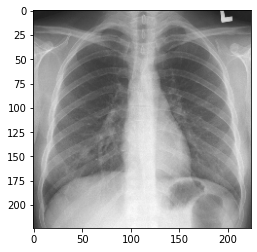

C'est satisfaisant


In [ ]:
# Checking the masked images
plt.figure()
plt.imshow(imgmask[12])
plt.show()
plt.imshow(data_X[12])
plt.show()
print("Satisfying enough")

In [ ]:
# WARNING, no need to run this cell, images are already in the correct repositories

# Adding masked images to their corresponding repository : COVID and NORMAL

# Training images
for i in range(len(imgmask)-100):
    if data_Y[i] == 1: # Covid
        Image.fromarray(imgmask[i].astype(np.uint8)).save('./apprentissage/covid/I{}.png'.format(i))
    else: # Normal
        Image.fromarray(imgmask[i].astype(np.uint8)).save('./apprentissage/normal/I{}.png'.format(i))

# Validation images
for i in range(len(imgmask)-100,len(imgmask)):
    if data_Y[i] == 1: # Covid
        Image.fromarray(imgmask[i].astype(np.uint8)).save('./test/covid/I{}.png'.format(i))
    else: # Normal
        Image.fromarray(imgmask[i].astype(np.uint8)).save('./test/normal/I{}.png'.format(i))